# test_13
This test circuit is a loop of current sources and inductors. 

<img src="test_13.png" width="600">  

The netlist generated by LTSpice:
```
* test_13.asc
L1 2 3 5 Rser=1e-12
I1 1 2 2 AC 2
L2 0 3 3 Rser=0
L3 2 1 1 Rser=0
L4 1 0 1 Rser=0
I2 0 1 1
I3 3 0 5
I4 2 3 3
;op
* ;.ac list 0.159154943091895
* ;K1 L3 L2 0.5
.ac dec 100 0.1 10
.backanno
.end
```
LTSpice generated the following error message: Inductor L3 is in a loop involving inductor L1 and other voltage sources and/or inductors making an overdefined circuit matrix. You will need to correct the circuit or add some series resistance.

L1 series resistance was set to 1e-12, but this caused a difference in the phase of the current in L2 and L4. See the notes in the AC analysis section below.

The netlist generated by LTSpice was modified to remove Rser=0 from inductor lines and 'AC 1' from I1. This is the modified net list:
```
* test_13a.asc
L1 2 3 5
I1 1 2 2
L2 0 3 3 
L3 2 1 1 
L4 1 0 1 
I2 0 1 1
I3 3 0 5
I4 2 3 3
;op
* ;.ac list 0.159154943091895
* ;K1 L3 L2 0.5
.ac dec 100 0.1 10
.backanno
.end
```

This netlist is read into the Symbolic Modified Nodal Analysis Jupyter notebook and the following circuit equations were generated.  
```
-I_L3 + I_L4 = -I₁ + I₂
I_L1 + I_L3 = I₁ - I₄
-I_L1 - I_L2 = -I₃ + I₄
-I_L1⋅L₁⋅s + v₂ - v₃ = 0
-I_L2⋅L₂⋅s - v₃ = 0
-I_L3⋅L₃⋅s - v₁ + v₂ = 0
-I_L4⋅L₄⋅s + v₁ = 0
```

In [41]:
import os
from sympy import *
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt
init_printing()

Copy the text strings generated by the Symbolic Modified Nodal Analysis Jupyter notebook to the cell below.

In [42]:
I_L4, I_L3, v3, v2, I2, L2, I3, v1, L1, I_L2, L3, L4, I4, I1, I_L1, s = symbols(' I_L4  I_L3  v3  v2  I2  L2  I3  v1  L1  I_L2  L3  L4  I4  I1  I_L1  s ')
A = Matrix([[0, 0, 0, 0, 0, -1, 1], [0, 0, 0, 1, 0, 1, 0], [0, 0, 0, -1, -1, 0, 0], [0, 1, -1, -L1*s, 0, 0, 0], [0, 0, -1, 0, -L2*s, 0, 0], [-1, 1, 0, 0, 0, -L3*s, 0], [1, 0, 0, 0, 0, 0, -L4*s]])
X = Matrix( [v1, v2, v3, I_L1, I_L2, I_L3, I_L4] )
Z = Matrix( [-I1 + I2, I1 - I4, -I3 + I4, 0, 0, 0, 0] )

equ = Eq(A*X,Z)
equ

⎡    -I_L3 + I_L4    ⎤   ⎡-I₁ + I₂⎤
⎢                    ⎥   ⎢        ⎥
⎢    I_L1 + I_L3     ⎥   ⎢I₁ - I₄ ⎥
⎢                    ⎥   ⎢        ⎥
⎢    -I_L1 - I_L2    ⎥   ⎢-I₃ + I₄⎥
⎢                    ⎥   ⎢        ⎥
⎢-I_L1⋅L₁⋅s + v₂ - v₃⎥ = ⎢   0    ⎥
⎢                    ⎥   ⎢        ⎥
⎢  -I_L2⋅L₂⋅s - v₃   ⎥   ⎢   0    ⎥
⎢                    ⎥   ⎢        ⎥
⎢-I_L3⋅L₃⋅s - v₁ + v₂⎥   ⎢   0    ⎥
⎢                    ⎥   ⎢        ⎥
⎣  -I_L4⋅L₄⋅s + v₁   ⎦   ⎣   0    ⎦

## Symbolic solution

In [43]:
symbolic_solution = solve(equ,X)
#symbolic_solution

In [44]:
left_side = list(symbolic_solution.keys())
right_side = list(symbolic_solution.values())

for i in range(len(symbolic_solution)):
    pprint(Eq(left_side[i],right_side[i]))

     -I₁⋅L₃⋅L₄⋅s + I₂⋅L₁⋅L₄⋅s + I₂⋅L₂⋅L₄⋅s + I₂⋅L₃⋅L₄⋅s - I₃⋅L₂⋅L₄⋅s - I₄⋅L₁⋅L
v₁ = ─────────────────────────────────────────────────────────────────────────
                                  L₁ + L₂ + L₃ + L₄                           

₄⋅s
───
   
     I₁⋅L₁⋅L₃⋅s + I₁⋅L₂⋅L₃⋅s + I₂⋅L₁⋅L₄⋅s + I₂⋅L₂⋅L₄⋅s - I₃⋅L₂⋅L₃⋅s - I₃⋅L₂⋅L₄
v₂ = ─────────────────────────────────────────────────────────────────────────
                                               L₁ + L₂ + L₃ + L₄              

⋅s - I₄⋅L₁⋅L₃⋅s - I₄⋅L₁⋅L₄⋅s
────────────────────────────
                            
     I₁⋅L₂⋅L₃⋅s + I₂⋅L₂⋅L₄⋅s - I₃⋅L₁⋅L₂⋅s - I₃⋅L₂⋅L₃⋅s - I₃⋅L₂⋅L₄⋅s + I₄⋅L₁⋅L₂
v₃ = ─────────────────────────────────────────────────────────────────────────
                                  L₁ + L₂ + L₃ + L₄                           

⋅s
──
  
       I₁⋅L₃ + I₂⋅L₄ + I₃⋅L₂ - I₄⋅L₂ - I₄⋅L₃ - I₄⋅L₄
I_L1 = ─────────────────────────────────────────────
                     L₁ + L₂ + L₃ + L₄              
       -I₁⋅L₃ - I₂⋅

In [45]:
I1

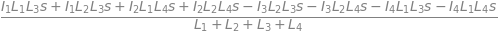

In [46]:
symbolic_solution[v2]

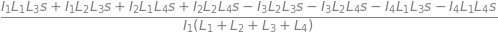

In [47]:
symbolic_solution[v2]/I1

## Numeric solution

In [48]:
# put the component values into dictionary format
component_values = {
    L1:5.0000e+00,
    I1:2.0000e+00,
    L2:3.0000e+00,
    L3:1.0000e+00,
    L4:1.0000e+00,
    I2:1.0000e+00,
    I3:5.0000e+00,
    I4:3.0000e+00}

Need to set the DC sources to zero.

In [49]:
component_values[I2] = 0
component_values[I3] = 0
component_values[I4] = 0

In [50]:
component_values

In [51]:
equ1a = equ.subs(component_values)
equ1a

⎡    -I_L3 + I_L4     ⎤   ⎡-2.0⎤
⎢                     ⎥   ⎢    ⎥
⎢     I_L1 + I_L3     ⎥   ⎢2.0 ⎥
⎢                     ⎥   ⎢    ⎥
⎢    -I_L1 - I_L2     ⎥   ⎢ 0  ⎥
⎢                     ⎥   ⎢    ⎥
⎢-5.0⋅I_L1⋅s + v₂ - v₃⎥ = ⎢ 0  ⎥
⎢                     ⎥   ⎢    ⎥
⎢  -3.0⋅I_L2⋅s - v₃   ⎥   ⎢ 0  ⎥
⎢                     ⎥   ⎢    ⎥
⎢  -I_L3⋅s - v₁ + v₂  ⎥   ⎢ 0  ⎥
⎢                     ⎥   ⎢    ⎥
⎣    -I_L4⋅s + v₁     ⎦   ⎣ 0  ⎦

The equations above are using the component values and the Laplace variable.

In [52]:
# solve the equations.
u1 = solve(equ1a,X)
u1 # the solution is too long to display correctly

The transfer function H(s)=V2(s)/I1

In [53]:
u1[v2]/component_values[I1]

## AC analysis
Solve equations for $\omega$ equal to 1 radian per second, s = 1j.



In [54]:
equ1a_1rad_per_s = equ1a.subs({s:1j})
equ1a_1rad_per_s  # display the equations

⎡    -I_L3 + I_L4     ⎤   ⎡-2.0⎤
⎢                     ⎥   ⎢    ⎥
⎢     I_L1 + I_L3     ⎥   ⎢2.0 ⎥
⎢                     ⎥   ⎢    ⎥
⎢    -I_L1 - I_L2     ⎥   ⎢ 0  ⎥
⎢                     ⎥   ⎢    ⎥
⎢-5.0⋅ⅈ⋅I_L1 + v₂ - v₃⎥ = ⎢ 0  ⎥
⎢                     ⎥   ⎢    ⎥
⎢  -3.0⋅ⅈ⋅I_L2 - v₃   ⎥   ⎢ 0  ⎥
⎢                     ⎥   ⎢    ⎥
⎢  -ⅈ⋅I_L3 - v₁ + v₂  ⎥   ⎢ 0  ⎥
⎢                     ⎥   ⎢    ⎥
⎣    -ⅈ⋅I_L4 + v₁     ⎦   ⎣ 0  ⎦

In [55]:
ans1 = solve(equ1a_1rad_per_s,X)
ans1

In [56]:
for name, value in ans1.items():
    print('{:5s}: mag: {:10.6f} phase: {:11.5f} deg'.format(str(name),float(abs(value)),float(arg(value)*180/np.pi)))

v1   : mag:   0.200000 phase:   -90.00000 deg
v2   : mag:   1.600000 phase:    90.00000 deg
v3   : mag:   0.600000 phase:    90.00000 deg
I_L1 : mag:   0.200000 phase:     0.00000 deg
I_L2 : mag:   0.200000 phase:   180.00000 deg
I_L3 : mag:   1.800000 phase:     0.00000 deg
I_L4 : mag:   0.200000 phase:   180.00000 deg


The results from LTSpice AC analysis at 0.159 Hz are shown below.   
```
       --- AC Analysis ---

frequency:	0.159155	Hz
V(2):	mag:        1.6 phase:         90° 	voltage
V(3):	mag:        0.6 phase:         90° 	voltage
V(1):	mag:        0.2 phase:        -90° 	voltage
I(L1):	mag:        0.2 phase: 5.72958e-12° 	device_current
I(L2):	mag:        0.2 phase:       -180° 	device_current
I(L3):	mag:        1.8 phase: -6.3662e-13° 	device_current
I(L4):	mag:        0.2 phase:       -180° 	device_current
I(I1):	mag:          2 phase:          0° 	device_current
I(I2):	mag:          0 phase:          0° 	device_current
I(I3):	mag:          0 phase:          0° 	device_current
I(I4):	mag:          0 phase:          0° 	device_current
```
Using the orginal circuit with the series resistance in L1 set to a small value, the phase of the currents in L2 and L4 didn't agree with the Python results. So the netlist was modified to put the small series resistance in L3, which allowed the phase in L2 and L3 to agree.

The new LTSpice net list with Rser=1e-20 added to L3. 
```
* C:\users\jeff32\My Documents\Solving Electrical Engineering Problems with Python Blog\MNA Test Circuits\test_13\test_13.asc
L1 2 3 5 Rser=0
I1 1 2 2 AC 2
L2 0 3 3 Rser=0
L3 2 1 1 Rser=1e-20
L4 1 0 1 Rser=0
I2 0 1 1
I3 3 0 5
I4 2 3 3
;op
* ;.ac list 0.159154943091895
* ;K1 L3 L2 0.5
.ac dec 100 0.1 10
.backanno
.end
```
The LTSt\pice results now agree.
```
       --- AC Analysis ---

frequency:	0.159155	Hz
V(2):	mag:        1.6 phase:         90° 	voltage
V(3):	mag:        0.6 phase:         90° 	voltage
V(1):	mag:        0.2 phase:        -90° 	voltage
I(L1):	mag:        0.2 phase: -5.15662e-19° 	device_current
I(L2):	mag:        0.2 phase:        180° 	device_current
I(L3):	mag:        1.8 phase: 5.72958e-20° 	device_current
I(L4):	mag:        0.2 phase:        180° 	device_current
I(I1):	mag:          2 phase:          0° 	device_current
I(I2):	mag:          0 phase:          0° 	device_current
I(I3):	mag:          0 phase:          0° 	device_current
I(I4):	mag:          0 phase:          0° 	device_current
```
There are some small numeric differences in some node voltages and phases because of the series resistance. Also note the the phase of the current for L2 and L4 from LTSpice is -180 vs +180 as calculated by SymPy.  

## AC Sweep
Looking at node 2 voltage and comparing the results with those obtained from LTSpice. The frequency sweep is from 0.1 Hz to 10 Hz.

Load the csv file of node 2 voltage over the sweep range and plot along with the results obtained from SymPy.

In [57]:
os.chdir('/home/jeff32/Documents/Solving Electrical Engineering Problems with Python Blog/MNA Test Circuits/test_13/') # change directory to net list location

fn = 'test_13.csv' # data from LTSpice
LTSpice_data = np.genfromtxt(fn, delimiter=',')

# change the working director back to the Jupyter folder
os.chdir('/home/jeff32/Documents/JupyterLab/Node Analysis/')  

In [58]:
# initaliaze some empty arrays
frequency = np.zeros(len(LTSpice_data))
voltage = np.zeros(len(LTSpice_data)).astype(complex)

# convert the csv data to complez numbers and store in the array
for i in range(len(LTSpice_data)):
    frequency[i] = LTSpice_data[i][0]
    voltage[i] = LTSpice_data[i][1] + LTSpice_data[i][2]*1j

Load the Laplace polyinominal for node 2

In [59]:
H = u1[v2]
H

In [60]:
num, denom = fraction(H) #returns numerator and denominator

# convert symbolic to numpy polynomial
a = np.array(Poly(num, s).all_coeffs(), dtype=float)
b = np.array(Poly(denom, s).all_coeffs(), dtype=float)
system_c1 = (a, b) # system for circuit 1

In [61]:
x = np.linspace(0.1*2*np.pi, 10*2*np.pi, 10000, endpoint=True)
w_c1, mag_c1, phase_c1 = signal.bode(system_c1, w=x) # returns: rad/s, mag in dB, phase in deg

Plot the results.  
Using

> np.unwrap(2 * phase) / 2) 

to keep the pahse plots the same.

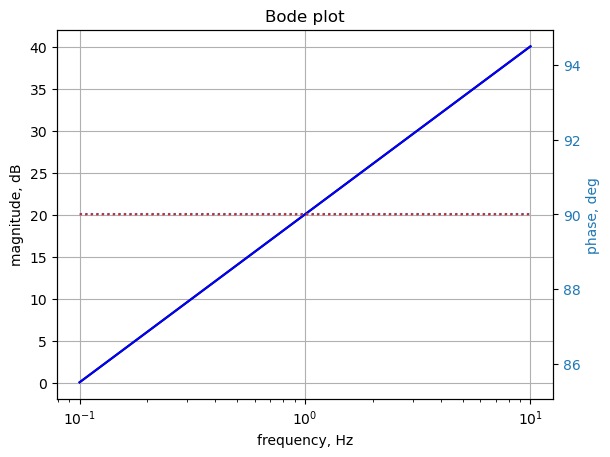

In [62]:
fig, ax1 = plt.subplots()
ax1.set_ylabel('magnitude, dB')
ax1.set_xlabel('frequency, Hz')

plt.semilogx(frequency, 20*np.log10(np.abs(voltage)),'-k')    # Bode magnitude plot
plt.semilogx(w_c1/(2*np.pi), mag_c1,'-b')    # Bode magnitude plot

ax1.tick_params(axis='y')
#ax1.set_ylim((-30,20))
plt.grid()

# instantiate a second y-axes that shares the same x-axis
ax2 = ax1.twinx()
color = 'tab:blue'

#plt.semilogx(frequency, np.angle(voltage)*180/np.pi,':',color=color)  # Bode phase plot
plt.semilogx(frequency, np.unwrap(2*np.angle(voltage)/2) *180/np.pi,':',color=color)  # Bode phase plot
plt.semilogx(w_c1/(2*np.pi), phase_c1,':',color='tab:red')  # Bode phase plot


ax2.set_ylabel('phase, deg',color=color)
ax2.tick_params(axis='y', labelcolor=color)
#ax2.set_ylim((-5,25))

plt.title('Bode plot')
plt.show()